# AXO_Histos for Efficiency

In [1]:
from dask.distributed import Client

client = Client("tls://192.168.121.122:8786")
client

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Connection method: Direct,
Dashboard: /user/colac-27@rhodes.edu/proxy/8787/status,
Comm: tls://192.168.121.122:8786,Workers: 0
Dashboard: /user/colac-27@rhodes.edu/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [2]:
import uproot as ur
import hist
import time
import json
import dask
import dill 
import operator
import numba
import sys
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.preprocessing import normalize
from pprint import pprint
from itertools import combinations, combinations_with_replacement
from collections import defaultdict

import awkward as ak
import dask_awkward as dak
import hist.dask as hda
import vector
vector.register_awkward()

from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import coffea.processor as processor
from coffea.dataset_tools import (
    apply_to_fileset,
    max_chunks,
    preprocess,
)

from ScoutingNanoAODSchema import ScoutingNanoAODSchema
client.upload_file("./ScoutingNanoAODSchema.py");
NanoAODSchema.warn_missing_crossrefs = False

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.backends.backend_pdf
from matplotlib.backends.backend_pdf import PdfPages

sys.setrecursionlimit(100000)

plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 50
hep.style.use('CMS')

/tmp/ipykernel_235/1419836343.py:24: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


## Coffea Histogram Processor
Here, we add in the information to makeAXOhists to create the efficiency curves. I have deleted much of the graphing information (invariant mass plots, etc.) to make the code a little less messy. 

In [21]:
thresholds = {
        'vtight'  : {'name'  : 'AXO VTight', 'score' : 25000/16},
        'tight'   : {'name'  : 'AXO Tight', 'score' : 20486/16},
        'nominal' : {'name'  : 'AXO Nominal', 'score' : 18580/16},
        'loose'   : {'name'  : 'AXO Loose', 'score' : 17596/16},
        'vloose'  : {'name'  : 'AXO VLoose', 'score' : 15717/16},
}

def multipage(filename, figs=None, dpi=200):
    """Creates a pdf with one page per plot"""
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
        print("No figures handed")
    for fig in figs:
        plt.figure(fig).savefig(pp, format='pdf')
    pp.close()

def getHist(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

def draw_thresholds(ax, threshold_map):
    for th in threshold_map.values():
        ax.axvline(x=th['score'], 
                   label=th['name'], 
                   color=ax._get_lines.get_next_color(),
                   linestyle='--',
                   linewidth=3,
        )

def draw_hist1d(hist_in, ax, label='', rebin=1, norm=False):
    counts, _, bins = hist_in[:,hist.rebin(rebin)].to_numpy()
    if len(counts)>0: # check that there are events to plot
        _counts = counts[0]/(np.sum(counts[0])*np.diff(bins)) if norm else counts[0]
        errs = np.sqrt(counts[0])/(np.sum(counts[0])*np.diff(bins)) if norm else np.sqrt(counts[0])
        
        _errs = np.where(_counts==0, 0, errs)
        bin_centres = 0.5*(bins[1:] + bins[:-1])
        l = ax.errorbar(x=bin_centres,y=_counts,yerr=_errs,linestyle='')
        color = l[0].get_color()
        ax.errorbar(x=bins[:-1],y=_counts,drawstyle='steps-post',label=label,color=color)
        
    else:
        l = ax.errorbar(x=[],y=[],yerr=[],drawstyle='steps-post') # plot nothing
        color = l[0].get_color()
        ax.errorbar(x=[],y=[],drawstyle='steps-post',label=label,color=color)
        
def draw_efficiency(ortho_hist, trig_hist, ax, label='', rebin=1, norm=False):
    ortho_counts, _, ortho_bins = ortho_hist[:,hist.rebin(rebin)].to_numpy()
    #print(f" Ortho: {ortho_counts[0]}")
    trig_counts, _, trig_bins = trig_hist[:,hist.rebin(rebin)].to_numpy()
    #print(f" Trig: {trig_counts[0]}")

    # Calculating efficiency
    eff = (trig_counts[0] / ortho_counts[0]) * 100
    x = 0.5*(trig_bins[0:-1] + trig_bins[1:])

    # Error bars
    f = trig_counts[0] / ortho_counts
    sig_trig = np.sqrt(trig_counts[0])
    sig_ortho = np.sqrt(ortho_counts[0])
    error = (f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)) * 100
    lower_error = error[0]
    upper_error = np.where(eff + error[0] >= 100, 100-eff, error) # Maybe not super efficient, but it works!
    upper_error = upper_error[0]
            
    capped_error = np.array([lower_error,upper_error])    

    # Plotting it                
    l = ax.errorbar(x=x, y=eff, yerr=capped_error, capsize=0, linestyle='')
    color = l[0].get_color()
    ax.errorbar(x=x, y=eff, label=label, color=color)

class MakeAXOHists (processor.ProcessorABC):
    def __init__(self, trigger_paths=[], has_scores=True, is_scouting=False, 
                 extra_cut='', thresholds=None, object_dict=None,
                 efficiency_triggers={}):
        if is_scouting:
             the_object_dict =  {
                            #   'ScoutingJet' :      {'cut' : [('pt', 30.)], 'label' : 'j'},
                                # Scouting_test doesn't have ScoutingJet
                                'ScoutingPFJet' : {'cut' :[('pt', 30.)], 'label' : 'j'}, 
                                'ScoutingElectron' : {'cut' : [('pt', 10)], 'label' : 'e'},
                                'ScoutingMuonNoVtx' :     {'cut' : [('pt', 3)], 'label' : '\mu'},
                                'ScoutingPhoton' :     {'cut' : [('pt', 10)], 'label' : '\gamma'},
                                'L1Jet' :    {'cut' : [('pt', 0.1)], 'label' : 'L1j'},
                                'L1EG' :     {'cut' : [('pt', 0.1)], 'label' : 'L1e'},
                                'L1Mu' :     {'cut' : [('pt', 0.1)], 'label' : 'L1\mu'},
                                'Jet' :      {'cut' : [('pt', 30.)], 'label' : 'j'},
                                'Electron' : {'cut' : [('pt', 10)], 'label' : 'e'},
                                'Muon' :     {'cut' : [('pt', 3)], 'label' : '\mu'}
                               }
        
        else:
            the_object_dict =  {'Jet' :      {'cut' : [('pt', 30.)], 'label' : 'j'},
                                'Electron' : {'cut' : [('pt', 10)], 'label' : 'e'},
                                'Muon' :     {'cut' : [('pt', 3)], 'label' : '\mu'},
                                'L1Jet' :    {'cut' : [('pt', 0.1)], 'label' : 'L1j'},
                                'L1EG' :     {'cut' : [('pt', 0.1)], 'label' : 'L1e'},
                                'L1Mu' :     {'cut' : [('pt', 0.1)], 'label' : 'L1\mu'}
                               }      
        self.run_dict = {
            'thresholds' : thresholds if thresholds is not None else {
                'AXOVTight_EMU'  : {'name'  : 'AXO VTight', 'score' : 25000/16},
                'AXOTight_EMU'   : {'name'  : 'AXO Tight', 'score' : 20486/16},
                'AXONominal_EMU' : {'name'  : 'AXO Nominal', 'score' : 18580/16},
                'AXOLoose_EMU'   : {'name'  : 'AXO Loose', 'score' : 17596/16},
                'AXOVLoose_EMU'  : {'name'  : 'AXO VLoose', 'score' : 15717/16},
            },
            'objects' : object_dict if object_dict is not None else the_object_dict
        }

        self.sorted_keys = sorted(self.run_dict['thresholds'],key=lambda i: self.run_dict['thresholds'][i]['score'])
        self.trigger_paths = trigger_paths
        self.has_scores = has_scores
        self.is_scouting = is_scouting
        self.extra_cut = extra_cut
        
        self.dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        self.score_axis = hist.axis.Regular(100, 0, 4000, name="score", label='Anomaly Score')
        self.mult_axis = hist.axis.Regular(200,0,201, name="mult", label=r'$N_{obj}$')
        self.pt_axis = hist.axis.Regular(500,0,5000, name="pt", label=r"$p_{T}$ [GeV]")
        self.eta_axis = hist.axis.Regular(150,-5,5, name="eta", label=r"$\eta$")
        self.phi_axis = hist.axis.Regular(30,-4,4, name="phi", label=r"$\phi$")
        self.met_axis = hist.axis.Regular(250,0,2500, name="met", label=r"$p^{miss}_{T} [GeV]$")
        self.ht_axis = hist.axis.Regular(100,0,2000, name="ht", label=r"$H_{T}$ [GeV]")
        self.minv_axis = hist.axis.Regular(3000,0,3000, name="minv", label=r"$m_{obj_{1},obj_{2}}$ [GeV]")
        
        self.eff_axis = hist.axis.Regular(300, 0, 1000, name="eff", label=r"$p_{T}$ [GeV]")
                
        # Efficiency initialization
        self.efficiency_triggers = efficiency_triggers
        

    def process(self, events):
        dataset = events.metadata['dataset']
        cutflow = defaultdict(int)
        cutflow['start'] = ak.num(events.event, axis=0)
        hist_dict = {}
               
        # Saturated-Jets event cut
        events = events[dak.all(events.L1Jet.pt<1000,axis=1)]
        # Saturated-MET event cut
        events = events[dak.flatten(events.L1EtSum.pt[(events.L1EtSum.etSumType==2) & (events.L1EtSum.bx==0)])<1040]      
        
        # Efficiency 
        if self.efficiency_triggers:
            for k in self.efficiency_triggers:
                ortho_trig = self.efficiency_triggers[k][0] # First trigger is orthogonal dataset
                int_trigs = self.efficiency_triggers[k][1:] # All others are triggers of interest

                ortho_trig_br = getattr(events,ortho_trig.split('_')[0])
                ortho_trig_path = '_'.join(ortho_trig.split('_')[1:])
                events_ortho = events[getattr(ortho_trig_br,ortho_trig_path)]
                
                # Getting scalar branches for the orthogonal trigger
                l1_etsums = events_ortho.L1EtSum
                ortho_l1_ht = l1_etsums[(events_ortho.L1EtSum.etSumType==1) & (events_ortho.L1EtSum.bx==0)]
                ortho_l1_met = l1_etsums[(events_ortho.L1EtSum.etSumType==2) & (events_ortho.L1EtSum.bx==0)]
                ortho_scouting_ht = ak.sum(events_ortho.ScoutingPFJet.pt,axis=1)
                ortho_scouting_ht = ak.sum(events_ortho.ScoutingPFJet.pt,axis=1)
                ortho_scouting_met = events_ortho.ScoutingMET.pt
                ortho_reco_ht = ak.sum(events_ortho.Jet.pt,axis=1)
                ortho_reco_met = events_ortho.PFMET.pt
                
                # Fill 1D histograms
                h_ortho_l1ht = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
                h_ortho_l1ht.fill(dataset=dataset, ht=ak.flatten(ortho_l1_ht.pt))
                hist_dict[f'ortho_l1ht_{ortho_trig}'] = h_ortho_l1ht  

                h_ortho_l1met = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
                h_ortho_l1met.fill(dataset=dataset, met=ak.flatten(ortho_l1_met.pt))
                hist_dict[f'ortho_l1met_{ortho_trig}'] = h_ortho_l1met
                
                h_ortho_scoutinght = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
                h_ortho_scoutinght.fill(dataset=dataset, ht=ortho_scouting_ht)
                hist_dict[f'ortho_scoutinght_{ortho_trig}'] = h_ortho_scoutinght                              

                h_ortho_scoutingmet = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
                h_ortho_scoutingmet.fill(dataset=dataset, met=ortho_scouting_met)
                hist_dict[f'ortho_scoutingmet_{ortho_trig}'] = h_ortho_scoutingmet
                
                h_ortho_recoht = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
                h_ortho_recoht.fill(dataset=dataset, ht=ortho_reco_ht)
                hist_dict[f'ortho_recoht_{ortho_trig}'] = h_ortho_recoht                              

                h_ortho_recomet = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
                h_ortho_recomet.fill(dataset=dataset, met=ortho_reco_met)
                hist_dict[f'ortho_recomet_{ortho_trig}'] = h_ortho_recomet
                
                for int_trig in int_trigs:
                    
                    int_trig_br = getattr(events, int_trig.split('_')[0])
                    int_trig_path = '_'.join(int_trig.split('_')[1:])
                    events_int = events[getattr(int_trig_br,int_trig_path) & getattr(ortho_trig_br,ortho_trig_path)]
                     
                    # Getting scalar branches for the trigger of interest
                    l1_etsums = events_int.L1EtSum
                    int_l1_ht = l1_etsums[(events_int.L1EtSum.etSumType==1) & (events_int.L1EtSum.bx==0)]
                    int_l1_met = l1_etsums[(events_int.L1EtSum.etSumType==2) & (events_int.L1EtSum.bx==0)]
                    int_scouting_ht = ak.sum(events_int.ScoutingPFJet.pt,axis=1)
                    int_scouting_met = events_int.ScoutingMET.pt
                    int_reco_ht = ak.sum(events_int.Jet.pt,axis=1)
                    int_reco_met = events_int.PFMET.pt
                    
                    # Fill 1D histograms
                    h_int_l1ht = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
                    h_int_l1ht.fill(dataset=dataset, ht=ak.flatten(int_l1_ht.pt))
                    hist_dict[f'int_l1ht_{int_trig}'] = h_int_l1ht  

                    h_int_l1met = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
                    h_int_l1met.fill(dataset=dataset, met=ak.flatten(int_l1_met.pt))
                    hist_dict[f'int_l1met_{int_trig}'] = h_int_l1met

                    h_int_scoutinght = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
                    h_int_scoutinght.fill(dataset=dataset, ht=int_scouting_ht)
                    hist_dict[f'int_scoutinght_{int_trig}'] = h_int_scoutinght                              

                    h_int_scoutingmet = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
                    h_int_scoutingmet.fill(dataset=dataset, met=int_scouting_met)
                    hist_dict[f'int_scoutingmet_{int_trig}'] = h_int_scoutingmet
                    
                    h_int_recoht = hda.hist.Hist(self.dataset_axis, self.ht_axis, storage="weight", label="nEvents")
                    h_int_recoht.fill(dataset=dataset, ht=int_reco_ht)
                    hist_dict[f'int_recoht_{int_trig}'] = h_int_recoht                              

                    h_int_recomet = hda.hist.Hist(self.dataset_axis, self.met_axis, storage="weight", label="nEvents")
                    h_int_recomet.fill(dataset=dataset, met=int_reco_met)
                    hist_dict[f'int_recomet_{int_trig}'] = h_int_recomet
                    
                    for obj,obj_dict in self.run_dict['objects'].items():
                        cut_list = obj_dict['cut']
                        label = obj_dict['label']
                        isL1Obj = 'L1' in obj
                        isScoutingObj = 'Scouting' in obj
                        ortho_br = getattr(events_ortho, obj)
                        int_br = getattr(events_int, obj)

                        # Filter only L1 Objects from BX==0
                        if isL1Obj:
                            ortho_br = ortho_br[ortho_br.bx==0]
                            int_br = int_br[int_br.bx==0]
                        
                        # Add appropriate cuts
                        for var, cut in cut_list:
                            ortho_mask = (getattr(ortho_br,var) > cut)
                            ortho_br = ortho_br[ortho_mask]
                            
                            int_mask = (getattr(int_br,var) > cut)
                            int_br = int_br[int_mask]
                            
                        # Fill 1D histograms with orthogonal trigger    
                        h_ortho_pt = hda.hist.Hist(self.dataset_axis, self.eff_axis, storage="weight", label="nEvents")
                        h_ortho_pt.fill(dataset=dataset, eff=dak.flatten(ortho_br.pt))
                        hist_dict[f'ortho_pt_{obj}_{ortho_trig}'] = h_ortho_pt 
                        
                        h_ortho_pt_0 = hda.hist.Hist(self.dataset_axis, self.eff_axis, storage="weight", label="nEvents")
                        h_ortho_pt_0.fill(dataset=dataset, eff=dak.flatten(ortho_br.pt[:,0:1]))
                        hist_dict[f'ortho_pt_0_{obj}_{ortho_trig}'] = h_ortho_pt_0
                        
                        h_ortho_pt_1 = hda.hist.Hist(self.dataset_axis, self.eff_axis, storage="weight", label="nEvents")
                        h_ortho_pt_1.fill(dataset=dataset, eff=dak.flatten(ortho_br.pt[:,1:2]))
                        hist_dict[f'ortho_pt_1_{obj}_{ortho_trig}'] = h_ortho_pt_1
                        
                        h_ortho_mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
                        h_ortho_mult.fill(dataset=dataset, mult=dak.num(ortho_br))
                        hist_dict[f'ortho_mult_{obj}_{ortho_trig}'] = h_ortho_mult
                        
                        h_ortho_eta = hda.hist.Hist(self.dataset_axis, self.eta_axis, storage="weight", label="nEvents")
                        h_ortho_eta.fill(dataset=dataset, eta=dak.flatten(ortho_br.eta))
                        hist_dict[f'ortho_eta_{obj}_{ortho_trig}'] = h_ortho_eta
                        
                        # Fill 1D Histograms with interest triggers
                        h_int_pt = hda.hist.Hist(self.dataset_axis, self.eff_axis, storage="weight", label="nEvents")
                        h_int_pt.fill(dataset=dataset, eff=dak.flatten(int_br.pt)) 
                        hist_dict[f'int_pt_{obj}_{int_trig}'] = h_int_pt
                        
                        h_int_pt_0 = hda.hist.Hist(self.dataset_axis, self.eff_axis, storage="weight", label="nEvents")
                        h_int_pt_0.fill(dataset=dataset, eff=dak.flatten(int_br.pt[:,0:1]))
                        hist_dict[f'int_pt_0_{obj}_{int_trig}'] = h_int_pt_0
                        
                        h_int_pt_1 = hda.hist.Hist(self.dataset_axis, self.eff_axis, storage="weight", label="nEvents")
                        h_int_pt_1.fill(dataset=dataset, eff=dak.flatten(int_br.pt[:,1:2]))
                        hist_dict[f'int_pt_1_{obj}_{int_trig}'] = h_int_pt_1
                                                                       
                        h_int_mult = hda.hist.Hist(self.dataset_axis, self.mult_axis, storage="weight", label="nEvents")
                        h_int_mult.fill(dataset=dataset, mult=dak.num(int_br)) 
                        hist_dict[f'int_mult_{obj}_{int_trig}'] = h_int_mult
                        
                        h_int_eta = hda.hist.Hist(self.dataset_axis, self.eta_axis, storage="weight", label="nEvents")
                        h_int_eta.fill(dataset=dataset, eta=dak.flatten(int_br.eta))
                        hist_dict[f'int_eta_{obj}_{int_trig}'] = h_int_eta

        # Trigger requirement
        for trigger_path in self.trigger_paths: # loop over trigger paths
            events_trig = None
                
            if trigger_path == "all":
                events_trig = events
                                
            else:
                trig_br = getattr(events,trigger_path.split('_')[0])
                trig_path = '_'.join(trigger_path.split('_')[1:])
                events_trig = events[getattr(trig_br,trig_path)] # select events passing this trigger

                                
            cutflow[trigger_path] = ak.num(events_trig.event, axis=0)

            # Process object collections - w/trigger
            for obj,obj_dict in self.run_dict['objects'].items():
                cut_list = obj_dict['cut']
                label = obj_dict['label']
                isL1Obj = 'L1' in obj
                isScoutingObj = 'Scouting' in obj
                br = getattr(events_trig, obj)
                
                # Filter only L1 Objects from BX==0
                if isL1Obj:
                    br = br[br.bx==0]

                # Apply list of cuts to relevant branches
                for var, cut in cut_list:
                    mask = (getattr(br,var) > cut)
                    br = br[mask]
                
                # Fill 1D histograms - w/trigger

                h_pt = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                h_pt.fill(dataset=dataset, pt=dak.flatten(br.pt))
                hist_dict[f'pt_{obj}_{trigger_path}'] = h_pt
                
                h_pt_0 = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                h_pt_0.fill(dataset=dataset, pt=dak.flatten(br.pt[:,0:1]))
                hist_dict[f'pt0_{obj}_{trigger_path}'] = h_pt_0
                
                h_pt_1 = hda.hist.Hist(self.dataset_axis, self.pt_axis, storage="weight", label="nEvents")
                h_pt_1.fill(dataset=dataset, pt=dak.flatten(br.pt[:,1:2]))
                hist_dict[f'pt1_{obj}_{trigger_path}'] = h_pt_1
       

        return {
            'cutflow' : cutflow,
            'hists'   : hist_dict,
            'trigger' : self.trigger_paths if len(self.trigger_paths)>0 else None
        }

    def postprocess(self, accumulator):
        return accumulator

# Removed pure events information

## Configure & Process Datasets

### Preprocess Input Files

In [86]:
url = "https://raw.githubusercontent.com/cms-l1-dpg/L1MenuRun3/master/official/L1Menu_Collisions2024_v1_1_0/PrescaleTable/L1Menu_Collisions2024_v1_1_0.csv"
df = pd.read_csv(url)
active_cols = [x for x in df.columns.to_list() if x not in ['Index','Name','Emergency']]
all_L1_seeds = df['Name'].to_numpy()
active_l1_seeds = df[(df[active_cols]>0).any(axis=1)]['Name'].to_numpy()
fulllumi_L1_seeds = df[df['2p0E34']>0]['Name'].to_numpy()

#with open('2024D_data_filelist.json') as json_file:
with open('2024_scouting_pfmonitor_filelist.json') as json_file:
    dataset = json.load(json_file)

#dataset_skimmed = {k:v for k,v in dataset.items() if k in ['Scouting_Golden_test']}
#dataset_skimmed = {k:v for k,v in dataset.items() if k in ['Scouting_test']}
dataset_skimmed = {k:v for k,v in dataset.items() if k in ['scouting_pfmonitor_2024E_381384_381594']}
#dataset_skimmed = {k:v for k,v in dataset.items() if k in ['scouting_pfmonitor_test']}

dataset_runnable, dataset_updated = preprocess(
    dataset_skimmed,
    align_clusters=False,
    step_size=100_000, #default
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

### Run Histogram Producer

In [87]:
#histpath = ['Scouting_Golden_test','hists']
#histpath = ['Scouting_test','hists']
histpath = ['scouting_pfmonitor_2024E_381384_381594', 'hists']
#histpath = ['scouting_pfmonitor_test', 'hists']

has_scores = True if 'wScores' in histpath[0] else False
#is_scouting = True if 'Scouting' in histpath[0] else False
is_scouting = True if 'scouting' in histpath[0] else False

if is_scouting:
    reco_objects = ["Jet","Electron","Muon","ScoutingPFJet","ScoutingElectron","ScoutingMuonNoVtx","ScoutingPhoton"]
else:
    reco_objects = ["Jet","Electron","Muon"]

#triggers = ['DST_PFScouting_JetHT','DST_PFScouting_DoubleMuon','DST_PFScouting_AXONominal','DST_PFScouting_AXOTight','HLT_L1AXOVTight']
# trigger_names = { 'all':"All Events",
#                       'DST_PFScouting_JetHT':"JetHT",
#                       'DST_PFScouting_DoubleMuon':"Double Muon",
#                       'DST_PFScouting_AXONominal':"AXO Nominal",
#                       'DST_PFScouting_AXOTight':"AXO Tight",
#                       'HLT_L1AXOVTight':"AXO Very Tight"}
triggers = ['DST_PFScouting_JetHT','L1_DoubleMu_15_7','DST_PFScouting_AXONominal','DST_PFScouting_DoubleMuon','L1_SingleJet200', 'DST_PFScouting_AXONominal']
trigger_names = { 'all':"All Events",
                      'DST_PFScouting_JetHT':"JetHT",
                      'L1_DoubleMu_15_7':"DoubleMu_15_7",
                      'DST_PFScouting_AXONominal':"AXO Nominal",
                      'DST_PFScouting_DoubleMuon':"Double Muon",
                      'L1_SingleJet200':"SingleJet_200"
                 ,
                      'DST_PFScouting_AXONominal':"AXO Nominal"}

efficiency_triggers = { "Muon Efficiency" : ["DST_PFScouting_JetHT",
                                       "L1_DoubleMu_15_7",
                                       "DST_PFScouting_AXONominal"],
                       "Jet Efficiency" : ["DST_PFScouting_DoubleMuon",
                                   "L1_SingleJet200",
                                   "DST_PFScouting_AXONominal"]}
efficiency_trigger_names = {"DST_PFScouting_JetHT" : "JetHT",
                            "L1_DoubleMu_15_7" : "L1_DoubleMu_15_7",
                            "DST_PFScouting_AXONominal" : "AXO Nominal",
                            "DST_PFScouting_DoubleMuon" : "Double Muon",
                            "L1_SingleJet200" : "L1_SingleJet200",
                            "DST_PFScouting_AXONominal" : "AXO Nominal"}

In [88]:
tstart = time.time()
to_compute = apply_to_fileset(
                MakeAXOHists(trigger_paths=triggers, 
                             has_scores=has_scores, 
                             is_scouting=is_scouting,
                             efficiency_triggers=efficiency_triggers),
                max_chunks(dataset_runnable, 300000),
                #max_chunks(dataset_runnable, 1), #quicktesting
                schemaclass=ScoutingNanoAODSchema,
                uproot_options={"allow_read_errors_with_report": (OSError, TypeError, KeyError)}
            )
(hist_result,) = dask.compute(to_compute)
print(f'{time.time()-tstart:.1f}s to process')
hist_result = hist_result[0]

818.3s to process


## Plotting

### Jet Efficiency with DoubleMuon

#### Leading and subleading pT

/tmp/ipykernel_235/336643990.py:62: RuntimeWarning: invalid value encountered in divide
  error = (f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)) * 100
/tmp/ipykernel_235/336643990.py:55: RuntimeWarning: invalid value encountered in divide
  eff = (trig_counts[0] / ortho_counts[0]) * 100
/tmp/ipykernel_235/336643990.py:59: RuntimeWarning: invalid value encountered in divide
  f = trig_counts[0] / ortho_counts


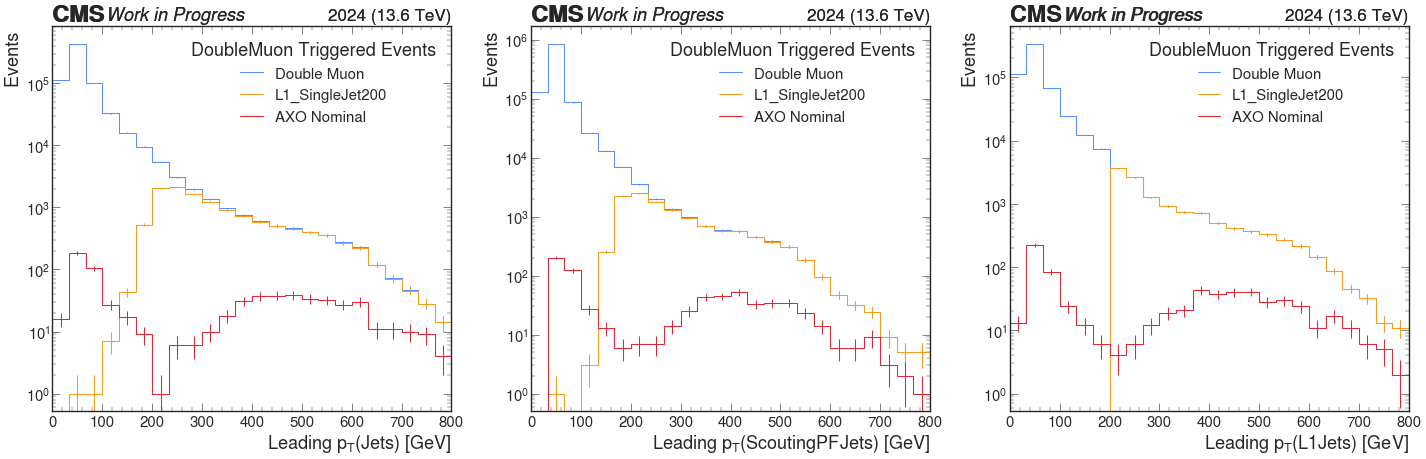

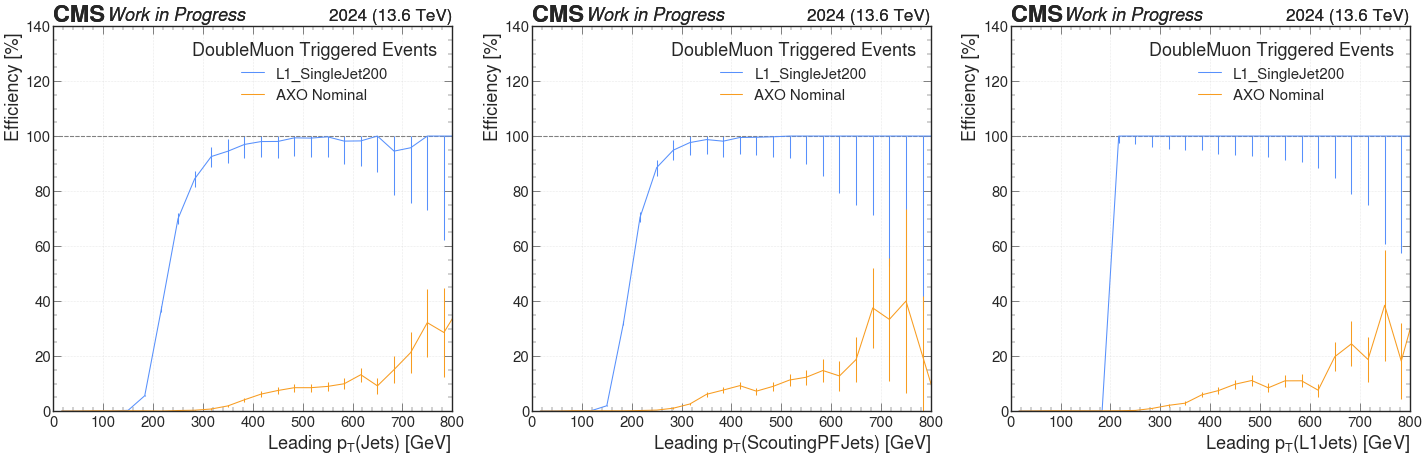

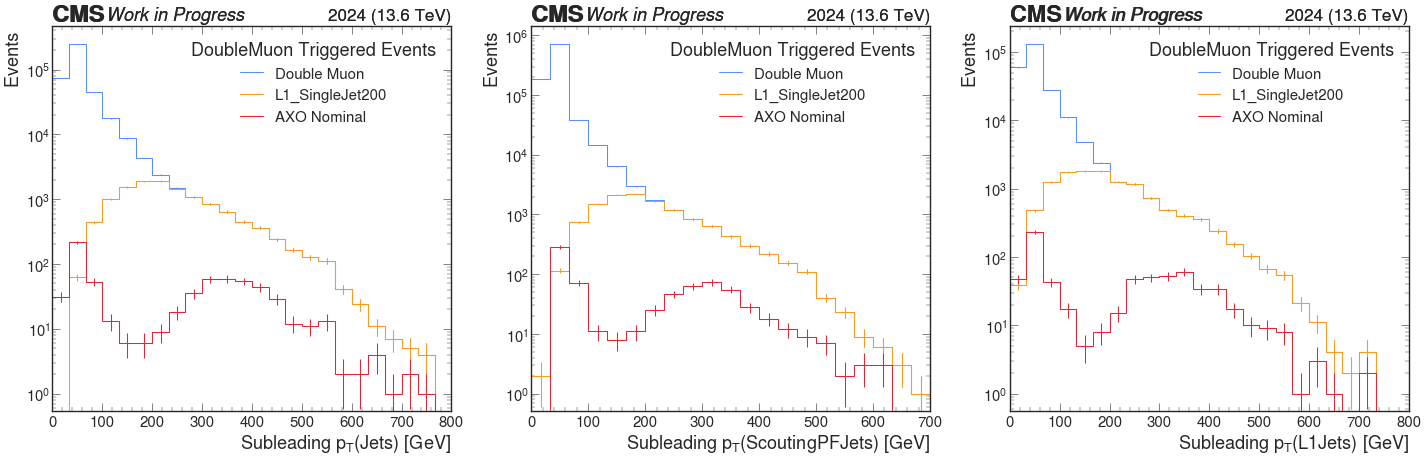

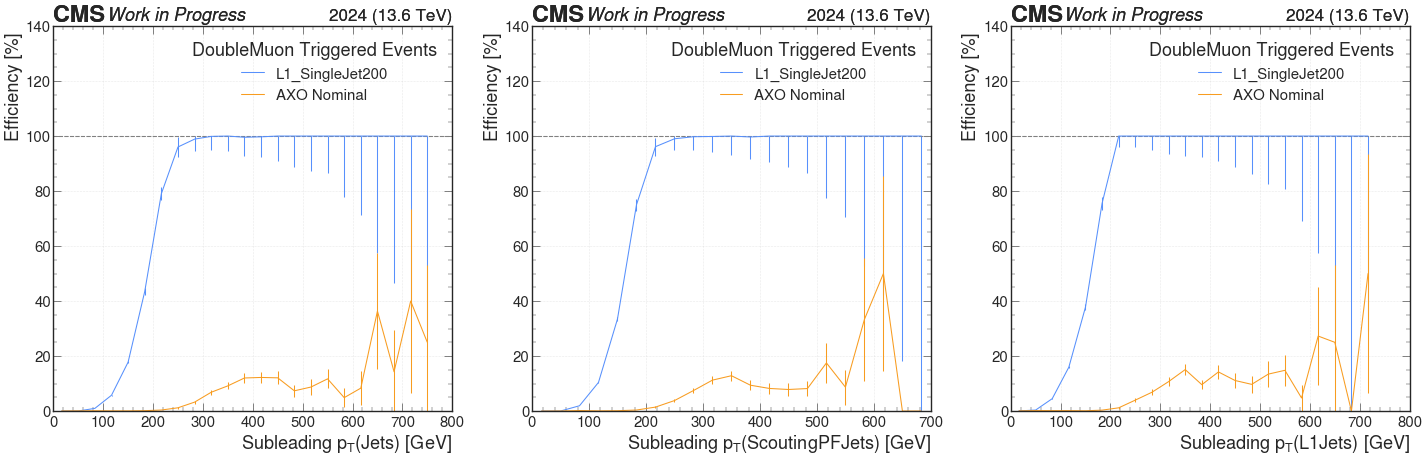

In [89]:
jet_eff = [v for k, v in efficiency_triggers.items() if k.startswith('Jet')]
jet_eff = jet_eff[0]

norm = False
rebin = 10

objects = ['Jet','ScoutingPFJet','L1Jet']
ortho_trig = jet_eff[0]
int_trigs = jet_eff[1:]

# Leading pT distributions
get_ortho_name = lambda s, suf=None: f'ortho_pt_0_{obj}_{suf}' if suf else f'ortho_pt_0_{obj}'
get_int_name = lambda s, suf=None: f'int_pt_0_{obj}_{suf}' if suf else f'int_pt_0_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,800), (0,800),(0,800)]

for i, obj in enumerate(objects):
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
    draw_hist1d(ortho_hist, ax[i], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)
    
    for j, int_trig in enumerate(int_trigs):
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
               
        if int_hist.size > 0:
            draw_hist1d(int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
            
            hep.cms.label('Work in Progress', ax=ax[i], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'Leading $p_{{T}}({obj+"s"})$ [GeV]', loc='right')
            ax[i].set_ylabel(f'Events {" [A.U.]" if norm else ""}', loc='top')
            # ymin, ymax = ax[i].get_ylim()
            # ax[i].set_ylim((ymin,ymax*1))
            ax[i].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
            ax[i].set_yscale('log')
        
        else:
            print(f"Skipped leading {obj} plot for {int_trig} due to empty histogram")
            continue
            
# Leading pT efficiency
get_ortho_name = lambda s, suf=None: f'ortho_pt_0_{obj}_{suf}' if suf else f'ortho_pt_0_{obj}'
get_int_name = lambda s, suf=None: f'int_pt_0_{obj}_{suf}' if suf else f'int_pt_0_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,800), (0,800), (0,800)]

for i, obj in enumerate(objects):
    for int_trig in int_trigs:
        ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
        
        if int_hist.size > 0:
            draw_efficiency(ortho_hist, int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

            hep.cms.label('Work in Progress', ax=ax[i], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].hlines(y=100, xmin=0, xmax=xrange[i][1],color='gray',linestyles='--')
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'Leading $p_{{T}}({obj+"s"})$ [GeV]', loc='right')
            ax[i].set_ylabel(f'Efficiency [%] {" [A.U.]" if norm else ""}', loc='top')
            ymin, ymax = ax[i].get_ylim()
            ax[i].set_ylim(0,140)
            ax[i].grid(visible=True)
            ax[i].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
        
        else:
            print(f"Skipped leading {obj} efficiency calculation for {int_trig} due to empty histogram")
            continue
            
# Subleading pT distributions
get_ortho_name = lambda s, suf=None: f'ortho_pt_1_{obj}_{suf}' if suf else f'ortho_pt_1_{obj}'
get_int_name = lambda s, suf=None: f'int_pt_1_{obj}_{suf}' if suf else f'int_pt_1_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,800), (0,700),(0,800)]

for i, obj in enumerate(objects):
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
    draw_hist1d(ortho_hist, ax[i], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)
    
    for j, int_trig in enumerate(int_trigs):
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
               
        if int_hist.size > 0:
            draw_hist1d(int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
            
            hep.cms.label('Work in Progress', ax=ax[i], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'Subleading $p_{{T}}({obj+"s"})$ [GeV]', loc='right')
            ax[i].set_ylabel(f'Events {" [A.U.]" if norm else ""}', loc='top')
            # ymin, ymax = ax[i].get_ylim()
            # ax[i].set_ylim((ymin,ymax*1))
            ax[i].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
            ax[i].set_yscale('log')
        
        else:
            print(f"Skipped subleading {obj} plot for {int_trig} due to empty histogram")
            continue

# Subleading pT efficiency
get_ortho_name = lambda s, suf=None: f'ortho_pt_1_{obj}_{suf}' if suf else f'ortho_pt_1_{obj}'
get_int_name = lambda s, suf=None: f'int_pt_1_{obj}_{suf}' if suf else f'int_pt_1_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,800), (0,700), (0,800)]

for i, obj in enumerate(objects):
    for int_trig in int_trigs:
        ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
        
        if int_hist.size > 0:
            draw_efficiency(ortho_hist, int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

            hep.cms.label('Work in Progress', ax=ax[i], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].hlines(y=100, xmin=0, xmax=xrange[i][1],color='gray',linestyles='--')
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'Subleading $p_{{T}}({obj+"s"})$ [GeV]', loc='right')
            ax[i].set_ylabel(f'Efficiency [%] {" [A.U.]" if norm else ""}', loc='top')
            ymin, ymax = ax[i].get_ylim()
            ax[i].set_ylim(0,140)
            ax[i].grid(visible=True)
            ax[i].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
        
        else:
            print(f"Skipped subleading {obj} efficiency calculation for {int_trig} due to empty histogram")
            continue

#### Multiplicity 

/tmp/ipykernel_235/336643990.py:55: RuntimeWarning: invalid value encountered in divide
  eff = (trig_counts[0] / ortho_counts[0]) * 100
/tmp/ipykernel_235/336643990.py:59: RuntimeWarning: invalid value encountered in divide
  f = trig_counts[0] / ortho_counts
/tmp/ipykernel_235/336643990.py:62: RuntimeWarning: invalid value encountered in divide
  error = (f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)) * 100
/tmp/ipykernel_235/3937640619.py:62: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[i].set_ylim(0,140)


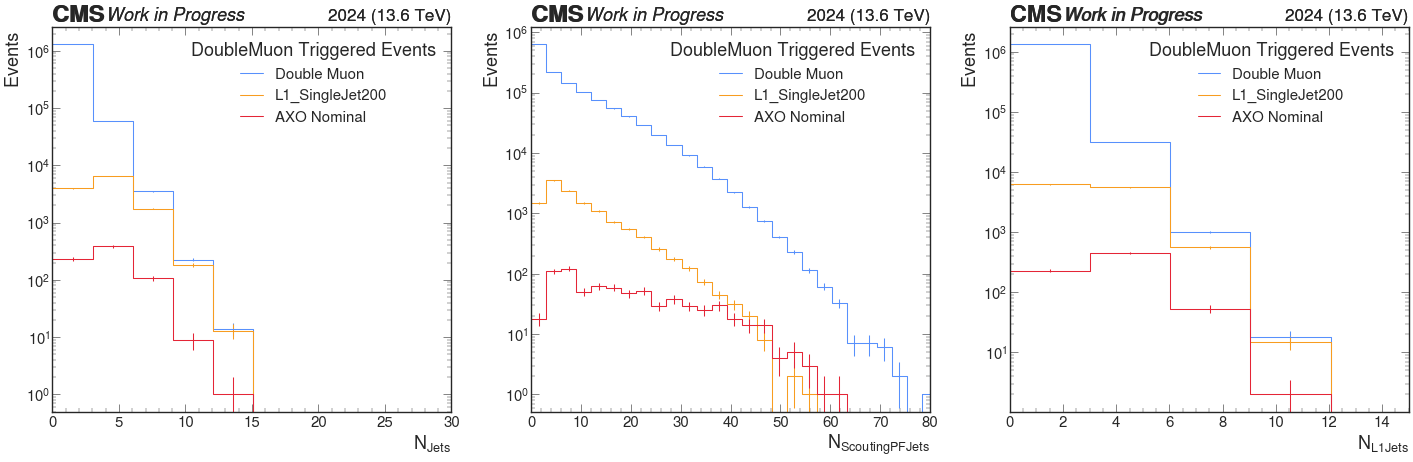

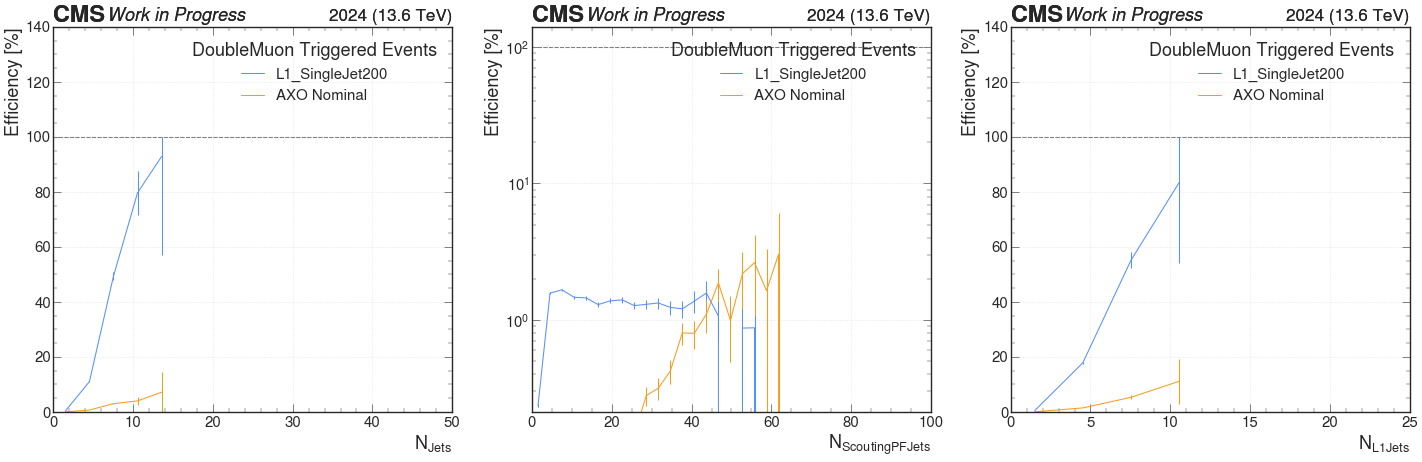

In [102]:
jet_eff = [v for k, v in efficiency_triggers.items() if k.startswith('Jet')]
jet_eff = jet_eff[0]

norm = False
rebin = 3

objects = ['Jet','ScoutingPFJet', 'L1Jet']
ortho_trig = jet_eff[0]
int_trigs = jet_eff[1:]

# Multiplicity distributions
get_ortho_name = lambda s, suf=None: f'ortho_mult_{obj}_{suf}' if suf else f'ortho_mult_{obj}'
get_int_name = lambda s, suf=None: f'int_mult_{obj}_{suf}' if suf else f'int_mult_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,30), (0,80),(0,15)]

for i, obj in enumerate(objects):
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
    draw_hist1d(ortho_hist, ax[i], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)
    
    for int_trig in int_trigs:
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
               
        if int_hist.size > 0:
            draw_hist1d(int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
            
            hep.cms.label('Work in Progress', ax=ax[i], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
            ax[i].set_ylabel(f'Events {" [A.U.]" if norm else ""}', loc='top')
            # ymin, ymax = ax[i].get_ylim()
            # ax[i].set_ylim((ymin,ymax*1))
            ax[i].set_yscale('log')
            ax[i].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
        
        else:
            print(f"Skipped {obj} plot for {int_trig} due to empty histogram")
            continue
            
# Multiplicity efficiency
get_ortho_name = lambda s, suf=None: f'ortho_mult_{obj}_{suf}' if suf else f'ortho_mult_{obj}'
get_int_name = lambda s, suf=None: f'int_mult_{obj}_{suf}' if suf else f'int_mult_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,50), (0,100), (0,25)]

for i, obj in enumerate(objects):
    for int_trig in int_trigs:
        ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
        
        if int_hist.size > 0:
            draw_efficiency(ortho_hist, int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

            hep.cms.label('Work in Progress', ax=ax[i], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].hlines(y=100, xmin=0, xmax=xrange[i][1],color='gray',linestyles='--')
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
            ax[i].set_ylabel(f'Efficiency [%]{" [A.U.]" if norm else ""}', loc='top')
            ymin, ymax = ax[i].get_ylim()
            ax[i].set_ylim(0,140)
            ax[i].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
            ax[i].grid(visible=True)
            #ax[i].set_yscale('log')
            ax[1].set_yscale('log')
        
        else:
            print(f"Skipped {obj} efficiency calculation for {int_trig} due to empty histogram")
            continue

#### Eta 

/tmp/ipykernel_235/1829674991.py:62: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[i].set_ylim(0,110)


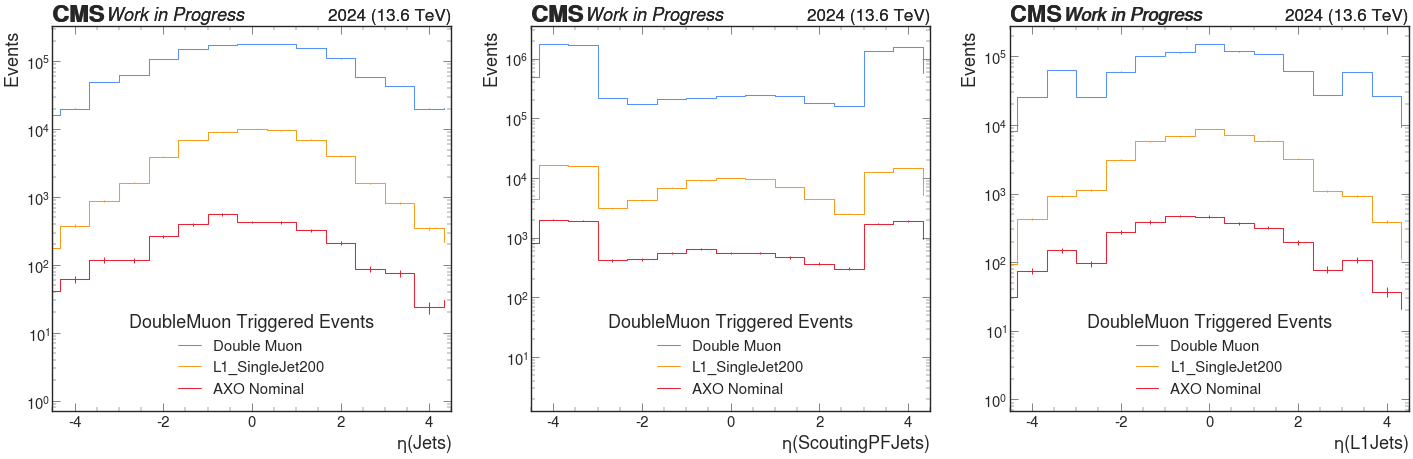

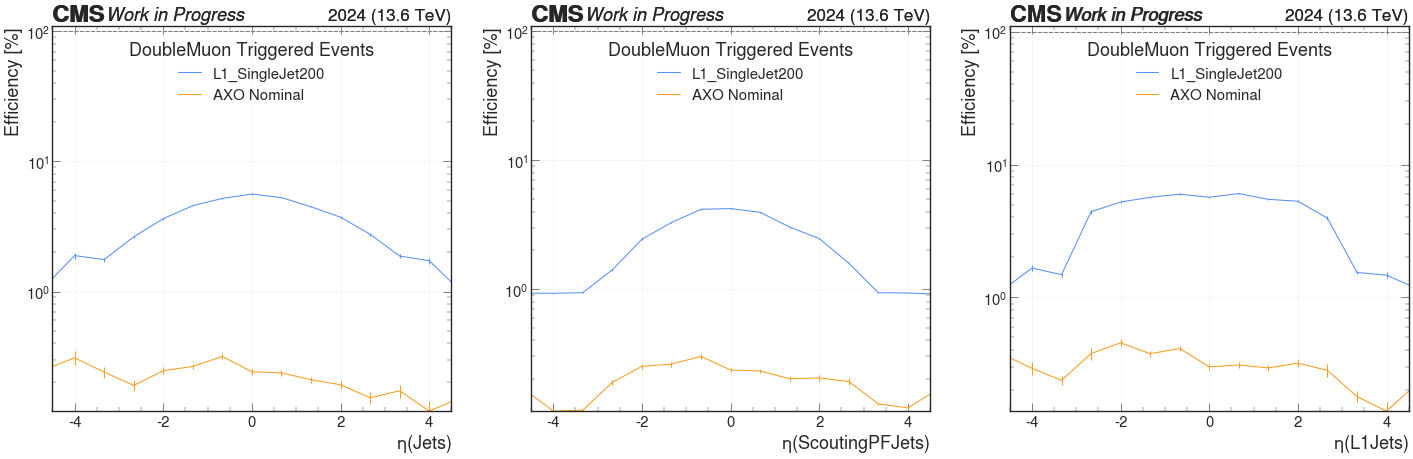

In [91]:
jet_eff = [v for k, v in efficiency_triggers.items() if k.startswith('Jet')]
jet_eff = jet_eff[0]

norm = False
rebin = 10

objects = ['Jet','ScoutingPFJet', 'L1Jet']
ortho_trig = jet_eff[0]
int_trigs = jet_eff[1:]

# Eta distributions
get_ortho_name = lambda s, suf=None: f'ortho_eta_{obj}_{suf}' if suf else f'ortho_eta_{obj}'
get_int_name = lambda s, suf=None: f'int_eta_{obj}_{suf}' if suf else f'int_eta_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(-4.5,4.5),(-4.5,4.5),(-4.5,4.5)]

for i, obj in enumerate(objects):
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
    draw_hist1d(ortho_hist, ax[i], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)
    
    for int_trig in int_trigs:
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
               
        if int_hist.size > 0:
            draw_hist1d(int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
            
            hep.cms.label('Work in Progress', ax=ax[i], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
            ax[i].set_ylabel(f'Events {" [A.U.]" if norm else ""}', loc='top')
            # ymin, ymax = ax[i].get_ylim()
            # ax[i].set_ylim((ymin,ymax*1))
            ax[i].set_yscale('log')
            ax[i].legend(title='DoubleMuon Triggered Events', frameon=False, loc='lower center')
        
        else:
            print(f"Skipped {obj} plot for {int_trig} due to empty histogram")
            continue

# Eta efficiency
get_ortho_name = lambda s, suf=None: f'ortho_eta_{obj}_{suf}' if suf else f'ortho_eta_{obj}'
get_int_name = lambda s, suf=None: f'int_eta_{obj}_{suf}' if suf else f'int_eta_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(-4.5,4.5),(-4.5,4.5),(-4.5,4.5)]

for i, obj in enumerate(objects):
    for int_trig in int_trigs:
        ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
        
        if int_hist.size > 0:
            draw_efficiency(ortho_hist, int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

            hep.cms.label('Work in Progress', ax=ax[i], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].hlines(y=100, xmin=-4.5, xmax=xrange[i][1],color='gray',linestyles='--')
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
            ax[i].set_ylabel(f'Efficiency [%]{" [A.U.]" if norm else ""}', loc='top')
            ymin, ymax = ax[i].get_ylim()
            ax[i].set_ylim(0,110)
            ax[i].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper center')
            ax[i].grid(visible=True)
            ax[i].set_yscale('log')
        
        else:
            print(f"Skipped {obj} efficiency calculation for {int_trig} due to empty histogram")
            continue

#### HT 

/tmp/ipykernel_235/336643990.py:62: RuntimeWarning: invalid value encountered in divide
  error = (f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)) * 100


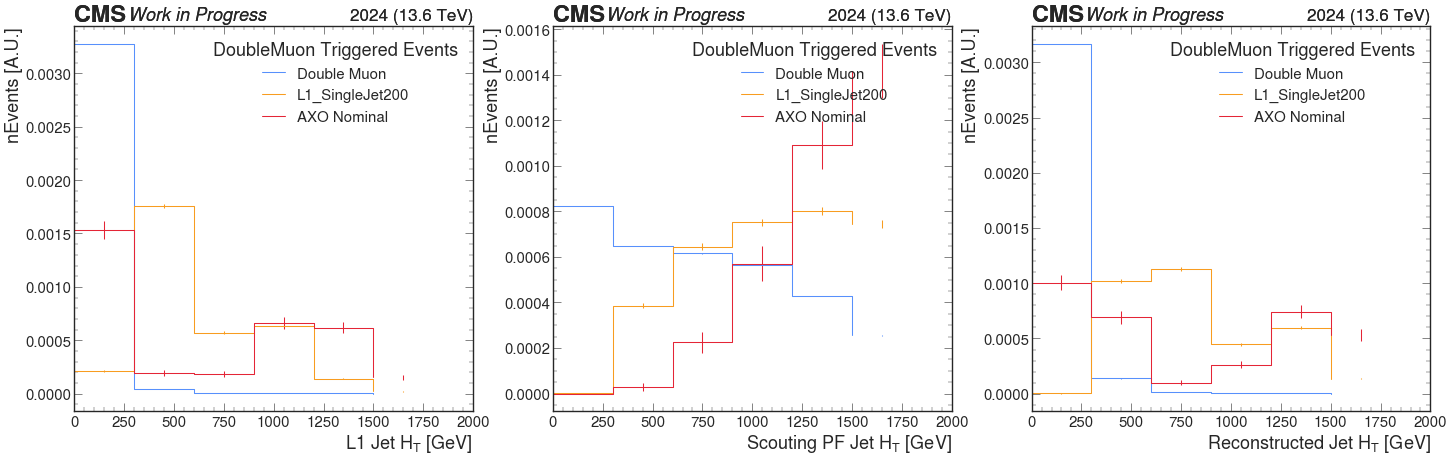

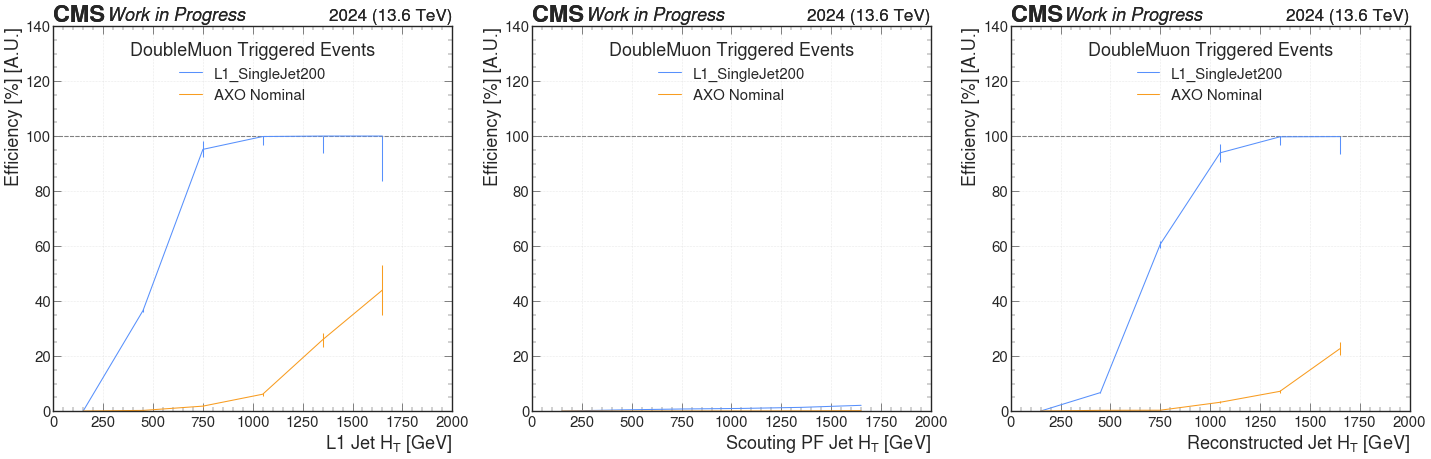

In [93]:
jet_eff = [v for k, v in efficiency_triggers.items() if k.startswith('Jet')]
jet_eff = jet_eff[0]

norm = True
rebin = 15

ortho_trig = jet_eff[0]
int_trigs = jet_eff[1:]

# HT distributions
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,2000),(0,2000),(0,2000)]

# L1 HT
get_ortho_name = lambda suf=None: f'ortho_l1ht_{ortho_trig}' if suf else f'ortho_l1ht'
get_int_name = lambda suf=None: f'int_l1ht_{int_trig}' if suf else f'int_l1ht'

ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
draw_hist1d(ortho_hist, ax[0], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)

for int_trig in int_trigs:
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    draw_hist1d(int_hist, ax[0], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
    
    hep.cms.label('Work in Progress', ax=ax[0], data=True, lumi=None, year='2024'.rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[0].set_xlim(0,2000)
    ax[0].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[0].set_xlabel(r'L1 Jet $H_{T}$ [GeV]', loc='right')
    ax[0].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
    
# Scouting HT
get_ortho_name = lambda suf=None: f'ortho_scoutinght_{ortho_trig}' if suf else f'ortho_scoutinght'
get_int_name = lambda suf=None: f'int_scoutinght_{int_trig}' if suf else f'int_scoutinght'

ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
draw_hist1d(ortho_hist, ax[1], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)

for int_trig in int_trigs:
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    draw_hist1d(int_hist, ax[1], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
    
    hep.cms.label('Work in Progress', ax=ax[1], data=True, lumi=None, year='2024'.rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[1].set_xlim(0,2000)
    ax[1].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[1].set_xlabel(r'Scouting PF Jet $H_{T}$ [GeV]', loc='right')
    ax[1].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
    
# Reconstructed HT
get_ortho_name = lambda suf=None: f'ortho_recoht_{ortho_trig}' if suf else f'ortho_recoht'
get_int_name = lambda suf=None: f'int_recoht_{int_trig}' if suf else f'int_recoht'

ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
draw_hist1d(ortho_hist, ax[2], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)

for int_trig in int_trigs:
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    draw_hist1d(int_hist, ax[2], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
    
    hep.cms.label('Work in Progress', ax=ax[2], data=True, lumi=None, year='2024'.rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[2].set_xlim(0,2000)
    ax[2].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[2].set_xlabel(r'Reconstructed Jet $H_{T}$ [GeV]', loc='right')
    ax[2].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
    
# HT efficiency
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,2000),(0,2000),(0,2000)]

# L1 HT
get_ortho_name = lambda suf=None: f'ortho_l1ht_{ortho_trig}' if suf else f'ortho_l1ht'
get_int_name = lambda suf=None: f'int_l1ht_{int_trig}' if suf else f'int_l1ht'

for int_trig in int_trigs:
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    
    if int_hist.size > 0:
        draw_efficiency(ortho_hist, int_hist, ax[0], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

        hep.cms.label('Work in Progress', ax=ax[0], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[0].hlines(y=100, xmin=0, xmax=xrange[0][1],color='gray',linestyles='--')
        ax[0].set_xlim(*xrange[0])
        ax[0].set_xlabel(r'L1 Jet $H_{T}$ [GeV]', loc='right')
        ax[0].set_ylabel(f'Efficiency [%]{" [A.U.]" if norm else ""}', loc='top')
        ax[0].set_ylim(0,140)
        ax[0].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper center')
        ax[0].grid(visible=True)
        
    else:
        print(f"Skipped L1 Jet HT efficiency calculation for {int_trig} due to empty histogram")
        continue

# Scouting HT
get_ortho_name = lambda suf=None: f'ortho_scoutinght_{ortho_trig}' if suf else f'ortho_scoutinght'
get_int_name = lambda suf=None: f'int_scoutinght_{int_trig}' if suf else f'int_scoutinght'

for int_trig in int_trigs:
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    
    if int_hist.size > 0:
        draw_efficiency(ortho_hist, int_hist, ax[1], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

        hep.cms.label('Work in Progress', ax=ax[1], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[1].hlines(y=100, xmin=0, xmax=xrange[1][1],color='gray',linestyles='--')
        ax[1].set_xlim(*xrange[1])
        ax[1].set_xlabel(r'Scouting PF Jet $H_{T}$ [GeV]', loc='right')
        ax[1].set_ylabel(f'Efficiency [%]{" [A.U.]" if norm else ""}', loc='top')
        ax[1].set_ylim(0,140)
        ax[1].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper center')
        ax[1].grid(visible=True)
        
    else:
        print(f"Skipped Scouting Jet HT efficiency calculation for {int_trig} due to empty histogram")
        continue
        
# Reconstructed HT 
get_ortho_name = lambda suf=None: f'ortho_recoht_{ortho_trig}' if suf else f'ortho_recoht'
get_int_name = lambda suf=None: f'int_recoht_{int_trig}' if suf else f'int_recoht'

for int_trig in int_trigs:
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    
    if int_hist.size > 0:
        draw_efficiency(ortho_hist, int_hist, ax[2], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

        hep.cms.label('Work in Progress', ax=ax[2], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[2].hlines(y=100, xmin=0, xmax=xrange[2][1],color='gray',linestyles='--')
        ax[2].set_xlim(*xrange[2])
        ax[2].set_xlabel(r'Reconstructed Jet $H_{T}$ [GeV]', loc='right')
        ax[2].set_ylabel(f'Efficiency [%]{" [A.U.]" if norm else ""}', loc='top')
        ax[2].set_ylim(0,140)
        ax[2].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper center')
        ax[2].grid(visible=True)
        
    else:
        print(f"Skipped Reconstructed Jet HT efficiency calculation for {int_trig} due to empty histogram")
        continue

#### MET 

/tmp/ipykernel_235/336643990.py:55: RuntimeWarning: invalid value encountered in divide
  eff = (trig_counts[0] / ortho_counts[0]) * 100
/tmp/ipykernel_235/336643990.py:59: RuntimeWarning: invalid value encountered in divide
  f = trig_counts[0] / ortho_counts
/tmp/ipykernel_235/336643990.py:62: RuntimeWarning: invalid value encountered in divide
  error = (f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)) * 100


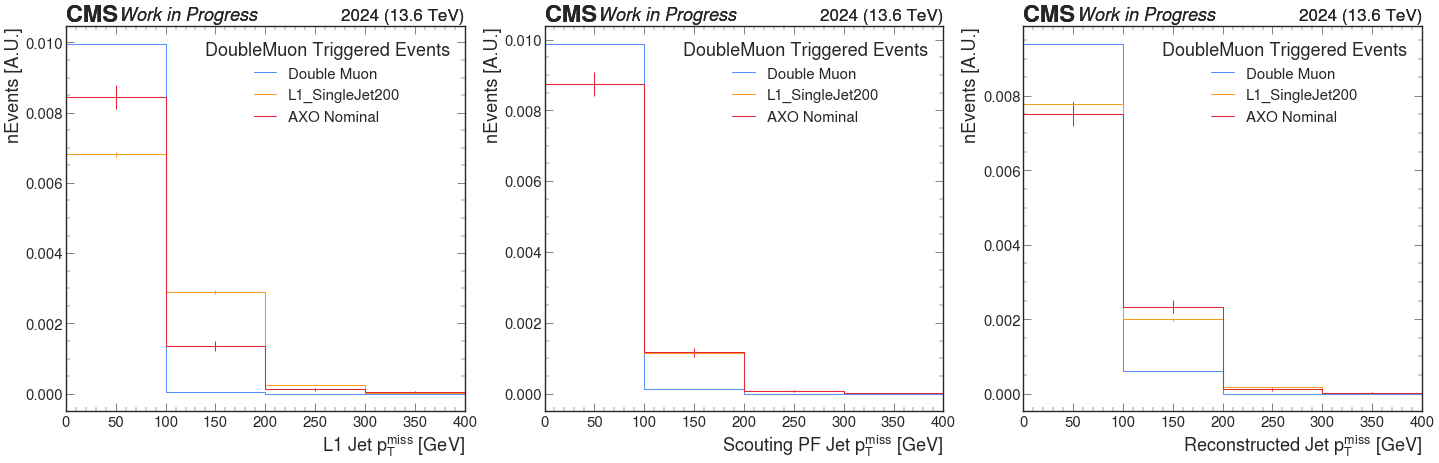

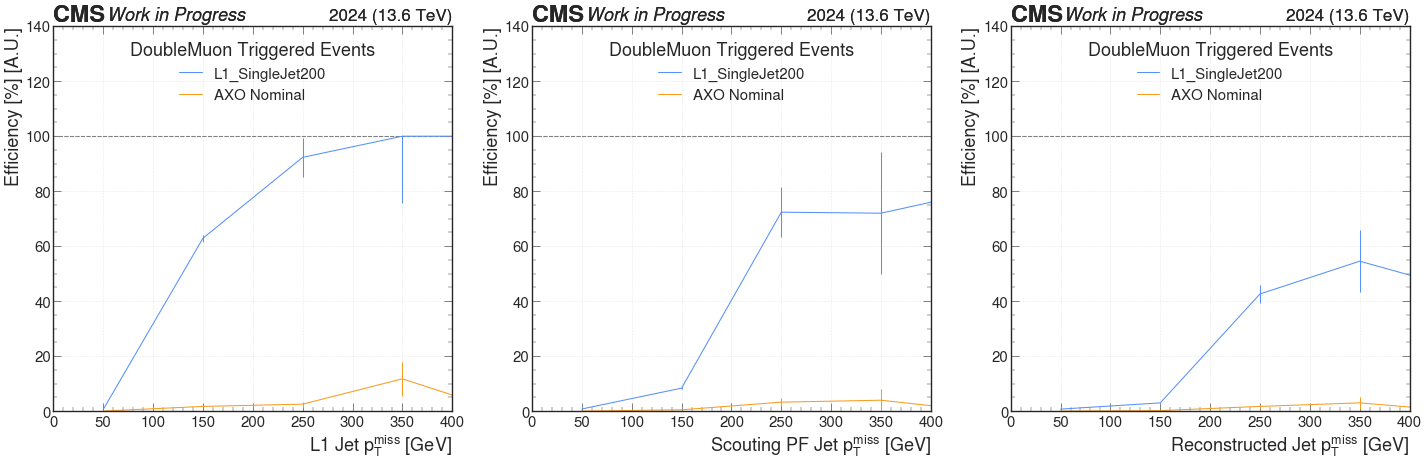

In [94]:
jet_eff = [v for k, v in efficiency_triggers.items() if k.startswith('Jet')]
jet_eff = jet_eff[0]

norm = True
rebin = 10

ortho_trig = jet_eff[0]
int_trigs = jet_eff[1:]

# MET distributions
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,400),(0,400),(0,400)]

# L1 MET
get_ortho_name = lambda suf=None: f'ortho_l1met_{ortho_trig}' if suf else f'ortho_l1met'
get_int_name = lambda suf=None: f'int_l1met_{int_trig}' if suf else f'int_l1met'

ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
draw_hist1d(ortho_hist, ax[0], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)

for int_trig in int_trigs:
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    draw_hist1d(int_hist, ax[0], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
    
    hep.cms.label('Work in Progress', ax=ax[0], data=True, lumi=None, year='2024'.rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[0].set_xlim(*xrange[0])
    ax[0].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[0].set_xlabel(r'L1 Jet $p^{miss}_{T}$ [GeV]', loc='right')
    ax[0].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
    
# Scouting MET
get_ortho_name = lambda suf=None: f'ortho_scoutingmet_{ortho_trig}' if suf else f'ortho_scoutingmet'
get_int_name = lambda suf=None: f'int_scoutingmet_{int_trig}' if suf else f'int_scoutingmet'

ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
draw_hist1d(ortho_hist, ax[1], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)

for int_trig in int_trigs:
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    draw_hist1d(int_hist, ax[1], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
    
    hep.cms.label('Work in Progress', ax=ax[1], data=True, lumi=None, year='2024'.rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[1].set_xlim(*xrange[1])
    ax[1].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[1].set_xlabel(r'Scouting PF Jet $p^{miss}_{T}$ [GeV]', loc='right')
    ax[1].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
    
# Reconstructed MET
get_ortho_name = lambda suf=None: f'ortho_recomet_{ortho_trig}' if suf else f'ortho_recomet'
get_int_name = lambda suf=None: f'int_recomet_{int_trig}' if suf else f'int_recomet'

ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
draw_hist1d(ortho_hist, ax[2], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)

for int_trig in int_trigs:
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    draw_hist1d(int_hist, ax[2], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
    
    hep.cms.label('Work in Progress', ax=ax[2], data=True, lumi=None, year='2024'.rstrip('_wScores').replace('_', ' '), com=13.6)
    ax[2].set_xlim(*xrange[2])
    ax[2].set_ylabel(f'nEvents{" [A.U.]" if norm else ""}', loc='top')
    ax[2].set_xlabel(r'Reconstructed Jet $p^{miss}_{T}$ [GeV]', loc='right')
    ax[2].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper right')
    
# MET efficiency
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,400),(0,400),(0,400)]

# L1 MET
get_ortho_name = lambda suf=None: f'ortho_l1met_{ortho_trig}' if suf else f'ortho_l1met'
get_int_name = lambda suf=None: f'int_l1met_{int_trig}' if suf else f'int_l1met'

for int_trig in int_trigs:
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    
    if int_hist.size > 0:
        draw_efficiency(ortho_hist, int_hist, ax[0], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

        hep.cms.label('Work in Progress', ax=ax[0], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[0].hlines(y=100, xmin=0, xmax=xrange[0][1],color='gray',linestyles='--')
        ax[0].set_xlim(*xrange[0])
        ax[0].set_xlabel(r'L1 Jet $p^{miss}_{T}$ [GeV]', loc='right')
        ax[0].set_ylabel(f'Efficiency [%]{" [A.U.]" if norm else ""}', loc='top')
        ax[0].set_ylim(0,140)
        ax[0].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper center')
        ax[0].grid(visible=True)
        
    else:
        print(f"Skipped L1 Jet MET efficiency calculation for {int_trig} due to empty histogram")
        continue

# Scouting MET
get_ortho_name = lambda suf=None: f'ortho_scoutingmet_{ortho_trig}' if suf else f'ortho_scoutingmet'
get_int_name = lambda suf=None: f'int_scoutingmet_{int_trig}' if suf else f'int_scoutingmet'

for int_trig in int_trigs:
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    
    if int_hist.size > 0:
        draw_efficiency(ortho_hist, int_hist, ax[1], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

        hep.cms.label('Work in Progress', ax=ax[1], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[1].hlines(y=100, xmin=0, xmax=xrange[1][1],color='gray',linestyles='--')
        ax[1].set_xlim(*xrange[1])
        ax[1].set_xlabel(r'Scouting PF Jet $p^{miss}_{T}$ [GeV]', loc='right')
        ax[1].set_ylabel(f'Efficiency [%]{" [A.U.]" if norm else ""}', loc='top')
        ax[1].set_ylim(0,140)
        ax[1].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper center')
        ax[1].grid(visible=True)
        
    else:
        print(f"Skipped Scouting PF Jet MET efficiency calculation for {int_trig} due to empty histogram")
        continue
        
# Reconstructed MET 
get_ortho_name = lambda suf=None: f'ortho_recomet_{ortho_trig}' if suf else f'ortho_recomet'
get_int_name = lambda suf=None: f'int_recomet_{int_trig}' if suf else f'int_recomet'

for int_trig in int_trigs:
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(ortho_trig)])
    int_hist = getHist(hist_result, histpath+[get_int_name(int_trig)])
    
    if int_hist.size > 0:
        draw_efficiency(ortho_hist, int_hist, ax[2], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

        hep.cms.label('Work in Progress', ax=ax[2], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
        ax[2].hlines(y=100, xmin=0, xmax=xrange[2][1],color='gray',linestyles='--')
        ax[2].set_xlim(*xrange[2])
        ax[2].set_xlabel(r'Reconstructed Jet $p^{miss}_{T}$ [GeV]', loc='right')
        ax[2].set_ylabel(f'Efficiency [%]{" [A.U.]" if norm else ""}', loc='top')
        ax[2].set_ylim(0,140)
        ax[2].legend(title='DoubleMuon Triggered Events', frameon=False, loc='upper center')
        ax[2].grid(visible=True)
        
    else:
        print(f"Skipped Reconstructed Jet MET efficiency calculation for {int_trig} due to empty histogram")
        continue

### Muon Efficiency with JetHT

#### Leading and subleading pT

/tmp/ipykernel_235/336643990.py:62: RuntimeWarning: invalid value encountered in divide
  error = (f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)) * 100
/tmp/ipykernel_235/336643990.py:55: RuntimeWarning: invalid value encountered in divide
  eff = (trig_counts[0] / ortho_counts[0]) * 100
/tmp/ipykernel_235/336643990.py:59: RuntimeWarning: invalid value encountered in divide
  f = trig_counts[0] / ortho_counts


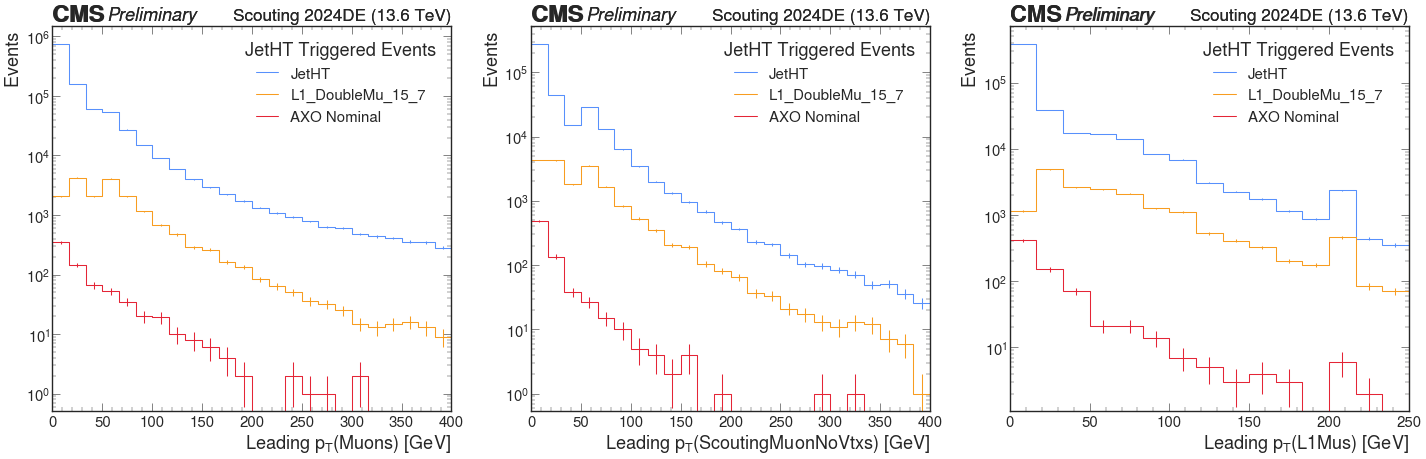

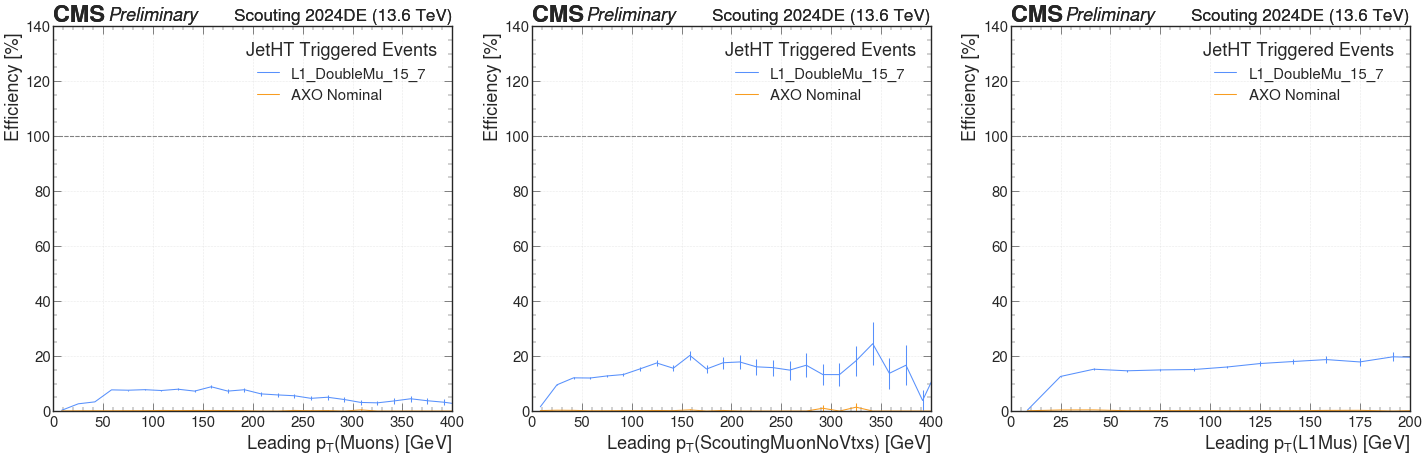

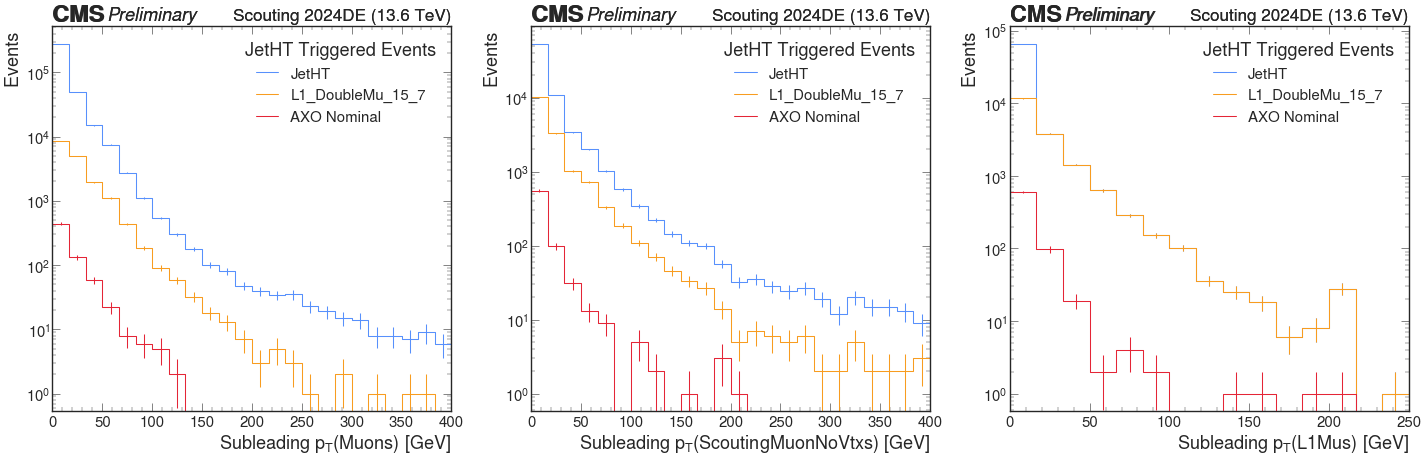

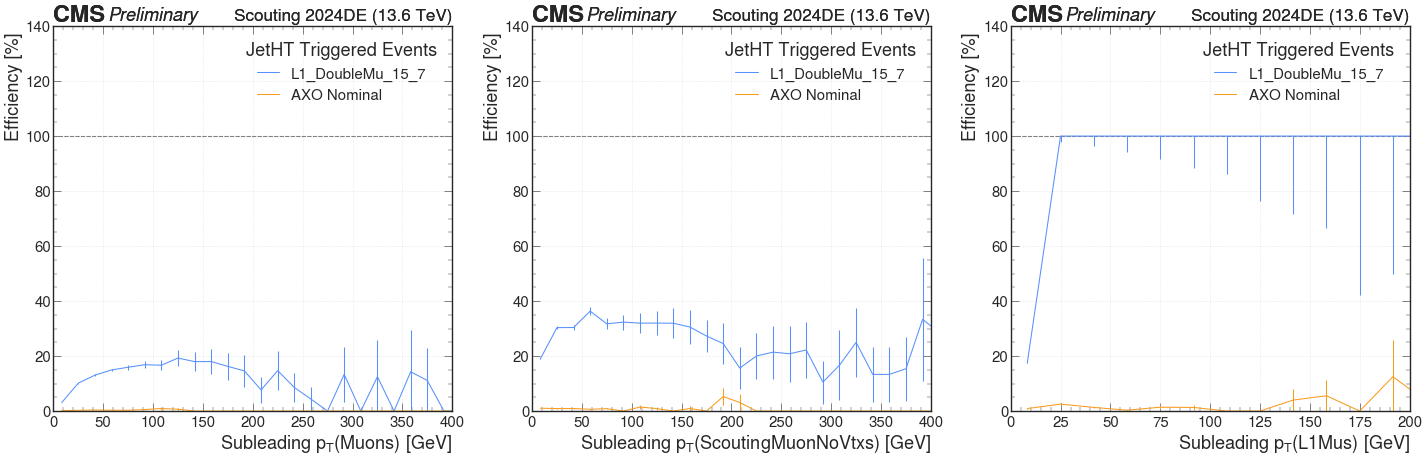

In [101]:
muon_eff = [v for k, v in efficiency_triggers.items() if k.startswith('Muon')]
muon_eff = muon_eff[0]

norm = False
rebin = 5

objects = ['Muon','ScoutingMuonNoVtx', 'L1Mu']
ortho_trig = muon_eff[0]
int_trigs = muon_eff[1:]

# Leading pT distributions
get_ortho_name = lambda s, suf=None: f'ortho_pt_0_{obj}_{suf}' if suf else f'ortho_pt_0_{obj}'
get_int_name = lambda s, suf=None: f'int_pt_0_{obj}_{suf}' if suf else f'int_pt_0_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,400), (0,400), (0,250)]

for i, obj in enumerate(objects):
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
    draw_hist1d(ortho_hist, ax[i], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)
    for int_trig in int_trigs:
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
               
        if int_hist.size > 0:
            draw_hist1d(int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year="Scouting 2024DE".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'Leading $p_{{T}}({obj+"s"})$ [GeV]', loc='right')
            ax[i].set_ylabel(f'Events {" [A.U.]" if norm else ""}', loc='top')
            ymin, ymax = ax[i].get_ylim()
            #ax[i].set_ylim((ymin,ymax*1))
            ax[i].set_yscale('log')
            ax[i].legend(title='JetHT Triggered Events', frameon=False, loc='upper right')
        
        else:
            print(f"Skipped leading {obj} plot for {int_trig} due to empty histogram")
            continue
            
# Leading pT efficiency
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,400), (0,400), (0,200)]

get_ortho_name = lambda s, suf=None: f'ortho_pt_0_{obj}_{suf}' if suf else f'ortho_pt_0_{obj}'
get_int_name = lambda s, suf=None: f'int_pt_0_{obj}_{suf}' if suf else f'int_pt_0_{obj}'

for i, obj in enumerate(objects):
    for int_trig in int_trigs:
        ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
                
        if int_hist.size > 0:
            draw_efficiency(ortho_hist, int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year="Scouting 2024DE".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].hlines(y=100, xmin=0, xmax=xrange[i][1],color='gray',linestyles='--')
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'Leading $p_{{T}}({obj+"s"})$ [GeV]', loc='right')
            ax[i].set_ylabel(f'Efficiency [%] {" [A.U.]" if norm else ""}', loc='top')
            ax[i].set_ylim(0,140)
            # ymin, ymax = ax[i].get_ylim()
            ax[i].grid(visible=True)
            ax[i].legend(title='JetHT Triggered Events', frameon=False, loc='upper right')
        
        else:
            print(f"Skipped leading {obj} efficiency calculation for {int_trig} due to empty histogram")
            continue

# Subleading pT distributions
get_ortho_name = lambda s, suf=None: f'ortho_pt_1_{obj}_{suf}' if suf else f'ortho_pt_1_{obj}'
get_int_name = lambda s, suf=None: f'int_pt_1_{obj}_{suf}' if suf else f'int_pt_1_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,400), (0,400), (0,250)]

for i, obj in enumerate(objects):
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
    draw_hist1d(ortho_hist, ax[i], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)
    for int_trig in int_trigs:
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
               
        if int_hist.size > 0:
            draw_hist1d(int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year="Scouting 2024DE".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'Subleading $p_{{T}}({obj+"s"})$ [GeV]', loc='right')
            ax[i].set_ylabel(f'Events {" [A.U.]" if norm else ""}', loc='top')
            ymin, ymax = ax[i].get_ylim()
            #ax[i].set_ylim((ymin,ymax*1))
            ax[i].set_yscale('log')
            ax[i].legend(title='JetHT Triggered Events', frameon=False, loc='upper right')
        
        else:
            print(f"Skipped subleading {obj} plot for {int_trig} due to empty histogram")
            continue

# Subleading pT efficiency
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,400), (0,400), (0,200)]

get_ortho_name = lambda s, suf=None: f'ortho_pt_1_{obj}_{suf}' if suf else f'ortho_pt_1_{obj}'
get_int_name = lambda s, suf=None: f'int_pt_1_{obj}_{suf}' if suf else f'int_pt_1_{obj}'

for i, obj in enumerate(objects):
    for int_trig in int_trigs:
        ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
                
        if int_hist.size > 0:
            draw_efficiency(ortho_hist, int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year="Scouting 2024DE".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].hlines(y=100, xmin=0, xmax=xrange[i][1],color='gray',linestyles='--')
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'Subleading $p_{{T}}({obj+"s"})$ [GeV]', loc='right')
            ax[i].set_ylabel(f'Efficiency [%] {" [A.U.]" if norm else ""}', loc='top')
            ax[i].set_ylim(0,140)
            # ymin, ymax = ax[i].get_ylim()
            ax[i].grid(visible=True)
            ax[i].legend(title='JetHT Triggered Events', frameon=False, loc='upper right')
        
        else:
            print(f"Skipped subleading {obj} efficiency calculation for {int_trig} due to empty histogram")
            continue
            

#### Multiplicity

/tmp/ipykernel_235/336643990.py:55: RuntimeWarning: invalid value encountered in divide
  eff = (trig_counts[0] / ortho_counts[0]) * 100
/tmp/ipykernel_235/336643990.py:59: RuntimeWarning: invalid value encountered in divide
  f = trig_counts[0] / ortho_counts
/tmp/ipykernel_235/336643990.py:62: RuntimeWarning: invalid value encountered in divide
  error = (f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)) * 100


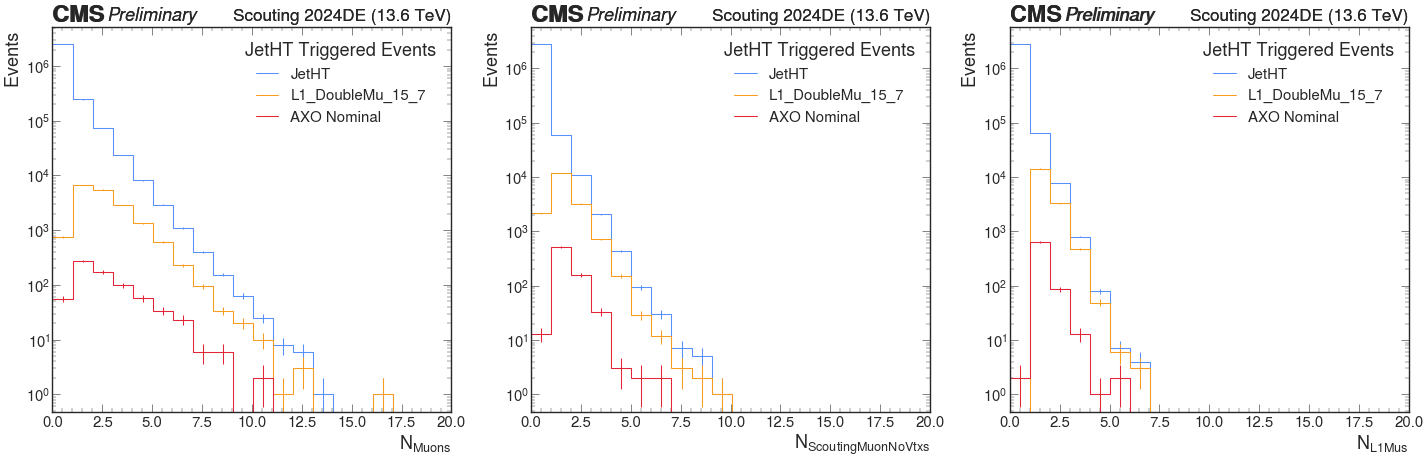

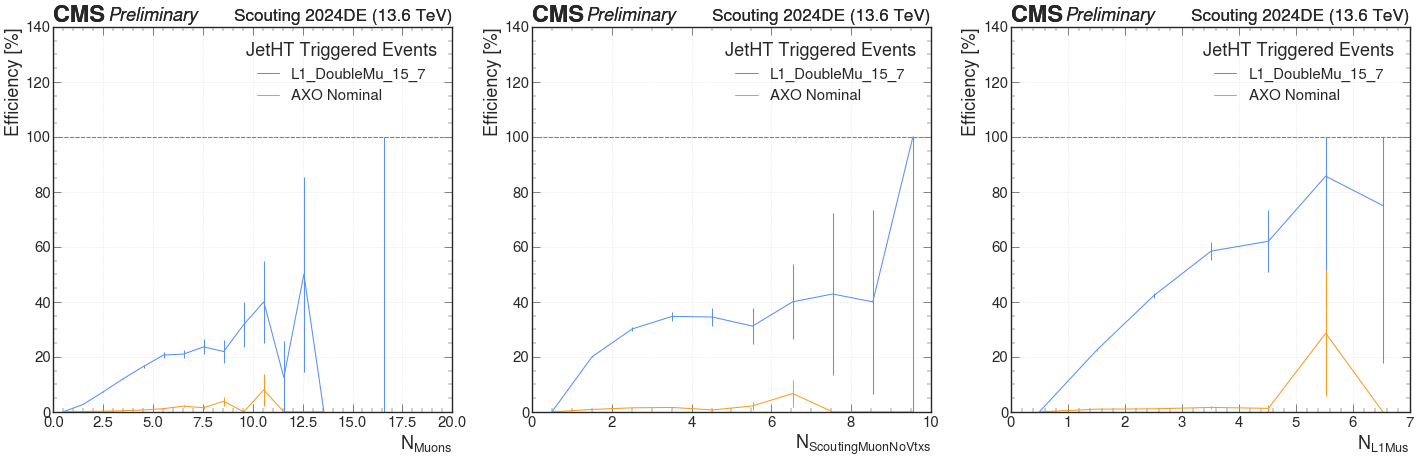

In [96]:
muon_eff = [v for k, v in efficiency_triggers.items() if k.startswith('Muon')]
muon_eff = muon_eff[0]

norm = False
rebin = 1

objects = ['Muon', 'ScoutingMuonNoVtx', 'L1Mu']
ortho_trig = muon_eff[0]
int_trigs = muon_eff[1:]

# Multiplicity distributions
get_ortho_name = lambda s, suf=None: f'ortho_mult_{obj}_{suf}' if suf else f'ortho_mult_{obj}'
get_int_name = lambda s, suf=None: f'int_mult_{obj}_{suf}' if suf else f'int_mult_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,20), (0,20),(0,20)]

for i, obj in enumerate(objects):
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
    draw_hist1d(ortho_hist, ax[i], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)
    
    for int_trig in int_trigs:        
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
               
        if int_hist.size > 0:
            draw_hist1d(int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
            
            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year="Scouting 2024DE".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
            ax[i].set_ylabel(f'Events {" [A.U.]" if norm else ""}', loc='top')
            # ymin, ymax = ax[i].get_ylim()
            # ax[i].set_ylim((ymin,ymax*1))
            ax[i].legend(title='JetHT Triggered Events', frameon=False,loc='upper right')
            ax[i].set_yscale('log')
        
        else:
            print(f"Skipped {obj} plot for {int_trig} due to empty histogram")
            continue

# Multiplicity efficiency
fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(0,20), (0,10), (0,7)]

get_ortho_name = lambda s, suf=None: f'ortho_mult_{obj}_{suf}' if suf else f'ortho_mult_{obj}'
get_int_name = lambda s, suf=None: f'int_mult_{obj}_{suf}' if suf else f'int_mult_{obj}'

# Multiplicity
for i, obj in enumerate(objects):
    for int_trig in int_trigs:
        ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
        
        if int_hist.size > 0:
            draw_efficiency(ortho_hist, int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

            hep.cms.label('Preliminary', ax=ax[i], data=True, lumi=None, year="Scouting 2024DE".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].hlines(y=100, xmin=0, xmax=xrange[i][1],color='gray',linestyles='--')
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'$N_{{{obj+"s"}}}$', loc='right')
            ax[i].set_ylabel(f'Efficiency [%]{" [A.U.]" if norm else ""}', loc='top')
            ymin, ymax = ax[i].get_ylim()
            ax[i].set_ylim(0,140)
            ax[i].grid(visible=True)
            ax[i].legend(title='JetHT Triggered Events', frameon=False,loc='upper right')
        
        else:
            print(f"Skipped {obj} efficiency calculation for {int_trig} due to empty histogram")
            continue

#### Eta 

/tmp/ipykernel_235/336643990.py:62: RuntimeWarning: invalid value encountered in divide
  error = (f*np.sqrt((sig_trig/trig_counts[0])**2 + (sig_ortho/ortho_counts[0])**2)) * 100
/tmp/ipykernel_235/735046296.py:62: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[i].set_ylim(0,140)
/tmp/ipykernel_235/336643990.py:55: RuntimeWarning: invalid value encountered in divide
  eff = (trig_counts[0] / ortho_counts[0]) * 100
/tmp/ipykernel_235/336643990.py:59: RuntimeWarning: invalid value encountered in divide
  f = trig_counts[0] / ortho_counts


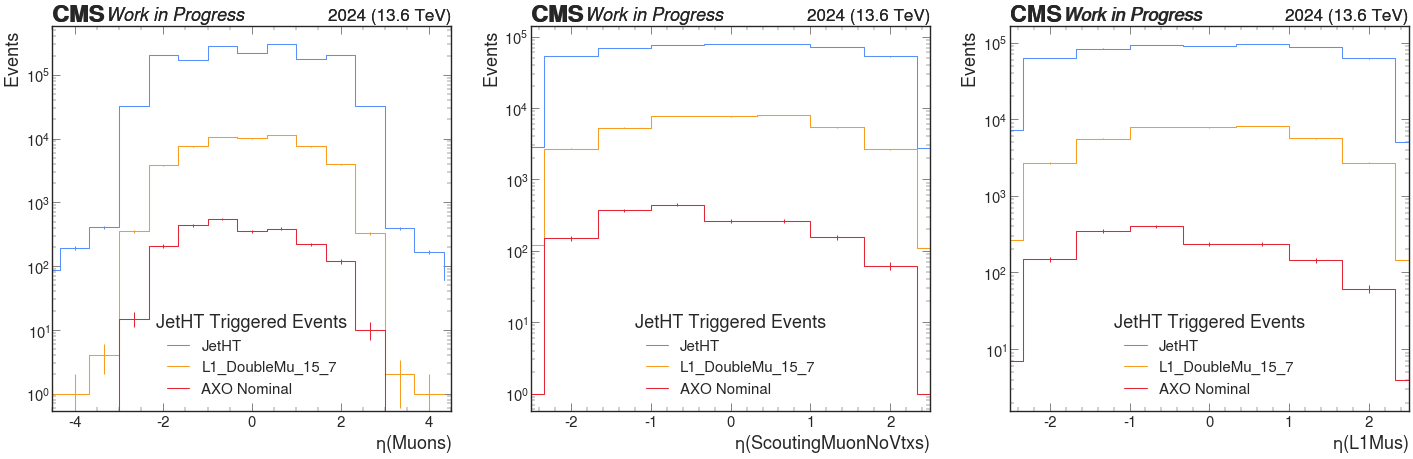

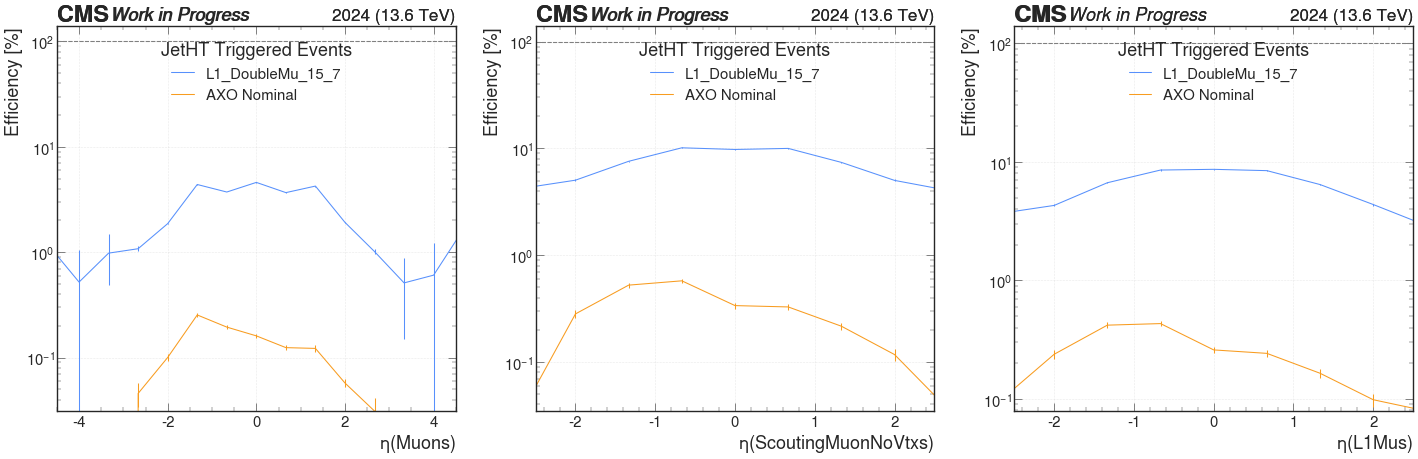

In [97]:
muon_eff = [v for k, v in efficiency_triggers.items() if k.startswith('Muon')]
muon_eff = muon_eff[0]

norm = False
rebin = 10

objects = ['Muon', 'ScoutingMuonNoVtx', 'L1Mu']
ortho_trig = muon_eff[0]
int_trigs = muon_eff[1:]

# Eta distributions
get_ortho_name = lambda s, suf=None: f'ortho_eta_{obj}_{suf}' if suf else f'ortho_eta_{obj}'
get_int_name = lambda s, suf=None: f'int_eta_{obj}_{suf}' if suf else f'int_eta_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(-4.5,4.5),(-2.5,2.5),(-2.5,2.5)]

for i, obj in enumerate(objects):
    ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
    draw_hist1d(ortho_hist, ax[i], label=efficiency_trigger_names[ortho_trig], rebin=rebin, norm=norm)
    
    for int_trig in int_trigs:
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
               
        if int_hist.size > 0:
            draw_hist1d(int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)
            
            hep.cms.label('Work in Progress', ax=ax[i], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
            ax[i].set_ylabel(f'Events {" [A.U.]" if norm else ""}', loc='top')
            # ymin, ymax = ax[i].get_ylim()
            # ax[i].set_ylim((ymin,ymax*1))
            ax[i].set_yscale('log')
            ax[i].legend(title='JetHT Triggered Events', frameon=False, loc='lower center')
        
        else:
            print(f"Skipped {obj} plot for {int_trig} due to empty histogram")
            continue
            
# Eta efficiency
get_ortho_name = lambda s, suf=None: f'ortho_eta_{obj}_{suf}' if suf else f'ortho_eta_{obj}'
get_int_name = lambda s, suf=None: f'int_eta_{obj}_{suf}' if suf else f'int_eta_{obj}'

fig, ax = plt.subplots(1, 3, figsize=(35, 10))
xrange = [(-4.5,4.5),(-2.5,2.5),(-2.5,2.5)]

for i, obj in enumerate(objects):
    for int_trig in int_trigs:
        ortho_hist = getHist(hist_result, histpath+[get_ortho_name(obj,ortho_trig)])
        int_hist = getHist(hist_result, histpath+[get_int_name(obj,int_trig)])
        
        if int_hist.size > 0:
            draw_efficiency(ortho_hist, int_hist, ax[i], label=efficiency_trigger_names[int_trig], rebin=rebin, norm=norm)

            hep.cms.label('Work in Progress', ax=ax[i], data=True, lumi=None, year="2024".rstrip('_wScores').replace('_', ' '), com=13.6)
            ax[i].hlines(y=100, xmin=-4.5, xmax=xrange[i][1],color='gray',linestyles='--')
            ax[i].set_xlim(*xrange[i])
            ax[i].set_xlabel(f'$\eta({obj+"s"})$', loc='right')
            ax[i].set_ylabel(f'Efficiency [%]{" [A.U.]" if norm else ""}', loc='top')
            ymin, ymax = ax[i].get_ylim()
            ax[i].set_ylim(0,140)
            ax[i].legend(title='JetHT Triggered Events', frameon=False, loc='upper center')
            ax[i].grid(visible=True)
            ax[i].set_yscale('log')
        
        else:
            print(f"Skipped {obj} efficiency calculation for {int_trig} due to empty histogram")
            continue

**Notes for muons:**
- L1 HT --> is it the same L1EtSum method? If so, what is the type/number?
- Scouting HT + Reconstructed HT --> will have to define new fills and histograms --> put this in the object loop 
- What is MET for the muons? Is PFMet even correct for the reconstructed jets?